In [40]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
# from shapely.geometry import MultiLineString, Point,LineString
from mpl_toolkits import axes_grid1
# import scipy.fftpack as fp
from scipy import linalg
from pysar.utils import readfile, utils as ut, plot as pp
# import scipy.io as sio
# import geopy.distance


plt.rcParams['figure.figsize'] = [20,20]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
def enu2los(e, n, u, inc_angle=34., head_angle=-12.873):
    """
    Parameters: e : np.array or float, displacement in east-west direction, east as positive
                n : np.array or float, displacement in north-south direction, north as positive
                u : np.array or float, displacement in vertical direction, up as positive
                inc_angle  : np.array or float, local incidence angle from vertical
                head_angle : np.array or float, satellite orbit from the north in clock-wise direction as positive
    For AlosA: inc_angle = 34, head_angle = -12.873
    For AlosD: inc_angle = 34, head_angle = -167.157
    For SenD: inc_angle = 34, head_angle = -168
    """
    # if input angle is azimuth angle
    # if (head_angle + 180.) > 45.:
    #     head_angle = azimuth2heading_angle(head_angle)

    inc_angle *= np.pi/180.
    head_angle *= np.pi/180.
    v_los = (-1 * e * np.cos(head_angle) * np.sin(inc_angle)
             + n * np.sin(head_angle) * np.sin(inc_angle)
             + u * np.cos(inc_angle))
    return v_los

# def get_transect(z,x0,y0,x1,y1):
#     length = int(np.hypot(x1-x0, y1-y0))
#     x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)
#     zi = z[y.astype(np.int), x.astype(np.int)]
#     return zi

def dist_point_from_line(m,c,x,y,dx,dy):
# finds the distance of a point at x ,y xoordinate
#from a line with Y =  mX +c
    d=np.sqrt((((x+m*y-m*c)/(m**2+1)-x)*dx)**2+((m*(x+m*y-m*c)/(m**2+1)+c-y)*dy)**2)
 #  a=m;b=-1;
  # d=np.abs(a*x+b*y+c)/np.sqrt(a**2+b**2)
    return d

def transect_yx(z, atr, start_yx, end_yx,start_fault_yx,end_fault_yx,ntrans,interpolation='nearest'):
    """Extract 2D matrix (z) value along the line [x0,y0;x1,y1]
    Ref link: http://stackoverflow.com/questions/7878398/how-to-e
              xtract-an-arbitrary-line-of-values-from-a-numpy-array

    Inputs:
        z        - (np.array)   2D data matrix
        atr      - (dictionary) 2D data matrix attribute dictionary
        start_yx - (list) y,x coordinate of start point
        end_yx   - (list) y,x coordinate of end   point
        interpolation - sampling/interpolation method, including:
                'nearest'  - nearest neighbour, by default
                'cubic'    - cubic interpolation
                'bilinear' - bilinear interpolation

    Output:
        transect - N*2 matrix containing distance - 1st col - and its corresponding 
                   values - 2nd col - along the line, N is the number of points.

    Example:
        transect = transect_yx(dem,demRsc,[10,15],[100,115])
    """

    # Extract the line
    [y0, x0] = start_yx
    [y1, x1] = end_yx
    [Yf0,Xf0] = start_fault_yx
    [Yf1,Xf1] = end_fault_yx

    length = int(np.hypot(x1-x0, y1-y0))
    transect=np.zeros([length,ntrans])

    # Define Fault line
    mf=float(Yf1-Yf0)/float((Xf1-Xf0))  # slope of the fault line
    cf=float(Yf0-mf*Xf0)   # intercept of the fault line
    df0=dist_point_from_line(mf,cf,x0,y0,1,1)   #distance of the profile start point from the Fault line
    df1=dist_point_from_line(mf,cf,x1,y1,1,1)  #distance of the profile end point from the Fault line

    mp=-1./mf  # slope of profile which is perpendicualr to the fault line
    x1=int((df0+df1)/np.sqrt(1+mp**2)+x0)    # correcting the end point of the profile to be on a line perpendicular to the Fault
    y1=int(mp*(x1-x0)+y0)
    
 
    Dint = (df0+df1)/length
    D = (np.arange(-df0,df1,Dint))
    XX0=[];XX1=[]
    YY0=[];YY1=[]
    if ntrans >1:       
        m=float(y1-y0)/float((x1-x0))
        c=float(y0-m*x0)
        m1=-1.0/m
        try:
            dp
        except:
            dp=1.0
        for i in range(0,ntrans):
            X0=i*dp/np.sqrt(1+m1**2)+x0
            Y0=m1*(X0-x0)+y0
            X1=i*dp/np.sqrt(1+m1**2)+x1
            Y1=m1*(X1-x1)+y1
            x, y = np.linspace(X0, X1, length), np.linspace(Y0, Y1, length)
            zi = z[np.rint(y).astype(np.int), np.rint(x).astype(np.int)]  # nearest neighbour
            XX0.append(X0);XX1.append(X1);
            YY0.append(Y0);YY1.append(Y1);
            transect[:,i]=zi
    else:
        X0 = x0
        Y0 = y0
        X1 = x1
        Y1 = y1
        
        
        
#      # X - Distance along the line
#     earth_radius = 6371.0e3    # in meter
#     coord = ut.coordinate(atr)
#     try:
#         atr['XMIN']
#         [lat0, lat1] = coord.yx2lalo([y0, y1], coord_type='y')
#         lat_c = (lat0 + lat1) / 2.
#         x_step = float(atr['X_STEP']) * np.pi/180.0 * earth_radius * np.cos(lat_c * np.pi/180)
#         y_step = float(atr['Y_STEP']) * np.pi/180.0 * earth_radius
#     except:
#         x_step = ut.range_ground_resolution(atr)
#         y_step = ut.azimuth_ground_resolution(atr)
#     dis_x = (x - x0) * x_step
#     dis_y = (y - y0) * y_step

#     transect[:, 0] = np.hypot(dis_x, dis_y)


#     transect = np.zeros([length, 2])            
    
#     # Y - Extract the value along the line
#     if interpolation.lower() == 'nearest':
#         zi = z[np.rint(y).astype(np.int), np.rint(x).astype(np.int)]
#     elif interpolation.lower() == 'cubic':
#         zi = scipy.ndimage.map_coordinates(z, np.vstack((y, x)))
#     elif interpolation.lower() == 'bilinear':
#         zi = scipy.ndimage.map_coordinates(z, np.vstack((y, x)), order=2)
#     else:
#         print('Unrecognized interpolation method: '+interpolation)
#         print('Continue with nearest ...')
#         zi = z[np.rint(y).astype(np.int), np.rint(x).astype(np.int)]  # nearest neighbour
        
#         transect[:, 1] = zi

           
    return XX0,XX1,YY0,YY1,D,transect


def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)



In [41]:
#Read velocity data and attributes from h5 file

f = h5py.File('/Users/admin/Desktop/Ganos/GanosT614F800AlosA/subset_geo_velocity_ECMWF_demCor_masked.h5')
atr=f.attrs
for key,value in f['velocity'].attrs.items():
    atr[key] = value
velocity = f['velocity'].get('velocity')
vel = velocity[0:velocity.shape[0]]

In [34]:
Xfirst = np.float(atr['X_FIRST'])
Yfirst = np.float(atr['Y_FIRST'])

Xstep = np.float(atr['X_STEP'])
Ystep = np.float(atr['Y_STEP'])

Xmax = (np.int(atr['XMAX'])+1)*Xstep
Ymax = (np.int(atr['YMAX'])+1)*Ystep

Xlast = Xmax+Xfirst
Ylast = Ymax+Yfirst

X = np.arange(Xfirst,Xlast,Xstep)
Y = np.arange(Yfirst,Ylast,Ystep)

X_L = list(np.round(X,2))
Y_L = list(np.round(Y,2))

In [35]:
X.shape

(2484,)

Y.shape

In [36]:
Y.shape

(1800,)

In [37]:
vel.shape

(1800, 2484)

In [38]:
#Define the linear function of fault
F1 = np.array([40.60,26.85])
F2 = np.array([40.75,27.37])

f1_x = X_L.index(F1[1])
f1_y = Y_L.index(F1[0])

f2_x = X_L.index(F2[1])
f2_y = Y_L.index(F2[0])

f1 = np.array([f1_y,f1_x])
f2 = np.array([f2_y,f2_x])

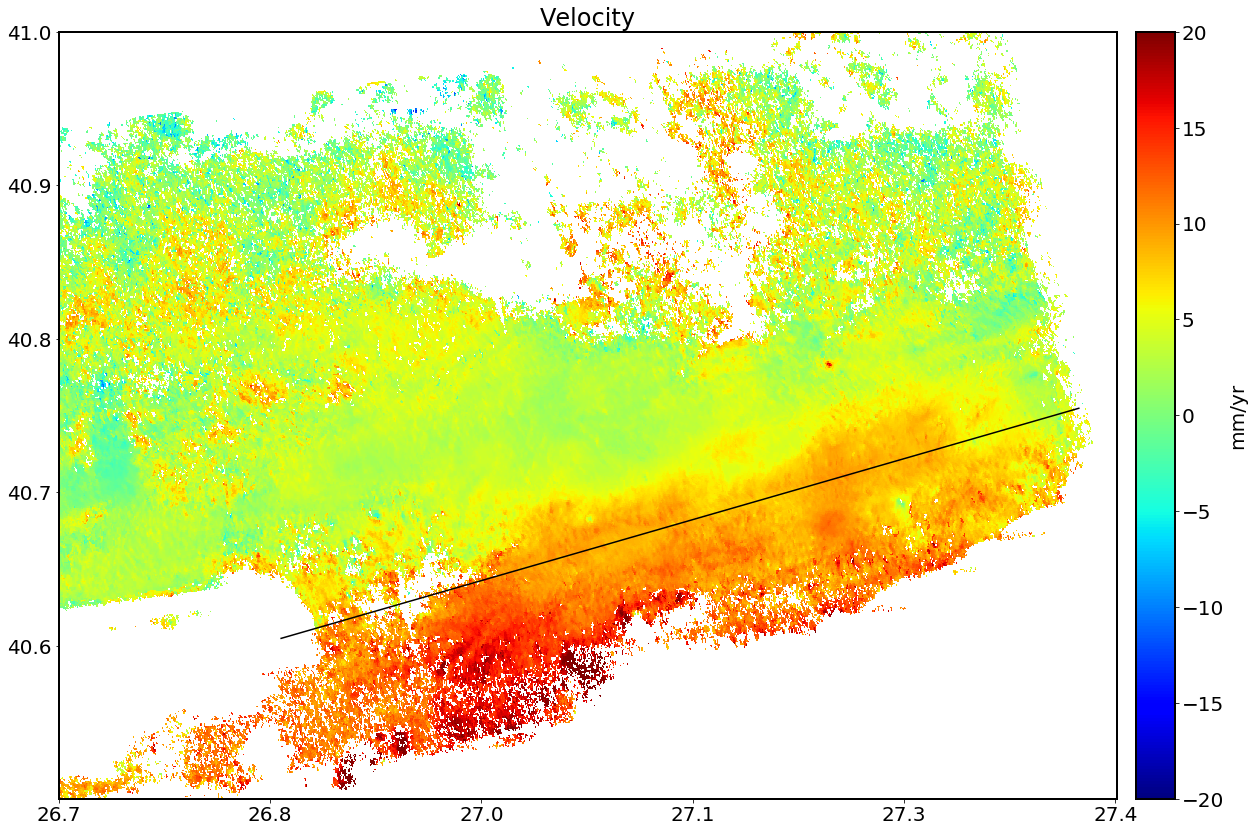

In [42]:
#Plot velocity and fault
fig,ax = plt.subplots()
FigVel = ax.imshow(vel*1000,vmin=-20,vmax=20,cmap='jet')
FigFault = plt.plot([f1_x,f2_x],[f1_y,f2_y],'k')
# ax.invert_yaxis()
plt.xlim(0,vel.shape[1])
locsX = np.arange(0,np.int(atr['XMAX'])+1,np.int((np.int(atr['XMAX'])+1)/5))
locsY = np.arange(0,np.int(atr['YMAX'])+1,np.int((np.int(atr['YMAX'])+1)/5))

plt.xticks(locsX,np.round(X[locsX],1))
plt.yticks(locsY,np.round(Y[locsY],1))

plt.title('Velocity')
add_colorbar(FigVel,label="mm/yr")
fig.savefig('velocity.png')

In [17]:
# #Subset the geo velocity to the velocity field
# # SubsetVel = vel[3450:6750,1100:5500]
# SubsetVel = vel
# # F1 = np.array([1950,0])
# # F2 = np.array([1000,4400])
# fig,ax = plt.subplots()
# FigVel = ax.imshow(SubsetVel,vmin=-0.02,vmax=0.02,cmap='jet')
# FigFault = plt.plot([F1[1],F2[1]],[F1[0],F2[0]],'k')
# ax.invert_yaxis()

In [43]:
#Calculate ramp from velocity

dshape = vel.shape
length, width = dshape[-2:]
num_pixel = length * width

# prepare input data
if len(dshape) == 3:
    vel = np.moveaxis(vel, 0, -1)        #reshape to (length, width, numDate)
    vel = vel.reshape(num_pixel, -1)
    dmean = np.mean(vel, axis=-1).flatten()
else:
    velR = vel.reshape(-1, 1)
    dmean = np.array(velR).flatten()

mask_in = np.ones((length, width), dtype=np.float32)
mask = (mask_in != 0).flatten()
mask[np.isnan(dmean)] = 0
mask[dmean == 0] = 0

xx,yy = np.meshgrid(np.arange(0,vel.shape[1]), np.arange(0,vel.shape[0]))
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
ones = np.ones(xx.shape, dtype=np.float32)
G = np.hstack((yy, xx, ones))

data = linalg.lstsq(G[mask, :], velR[mask, :], cond=1e-15)[0]
ramp = np.dot(G, data)

#Reshape ramp to velocity dimensions

ramp_sh = np.reshape(ramp,(vel.shape[0],vel.shape[1]))

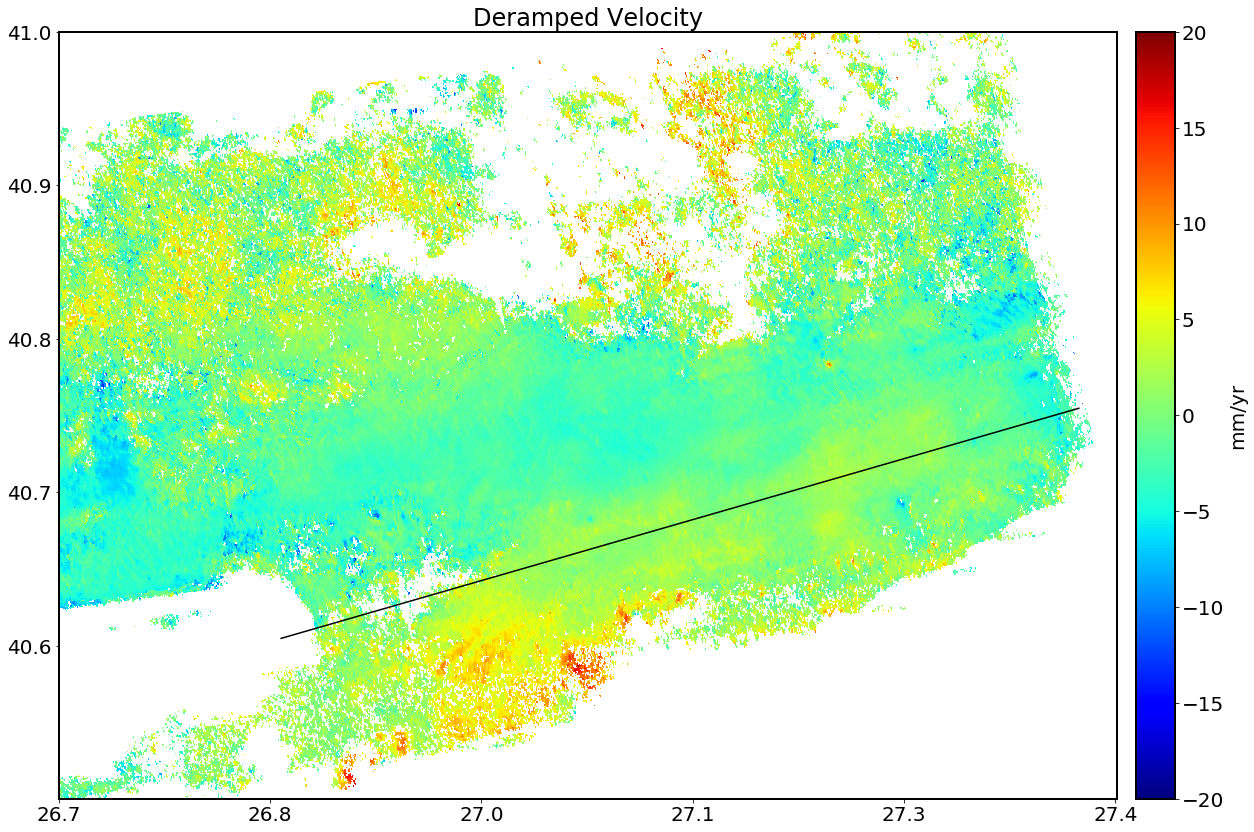

In [44]:
#Deramp and plot velocity
drmpdVel = vel-ramp_sh
fig,ax = plt.subplots()
FigVel = ax.imshow(drmpdVel*1000,vmin=-20,vmax=20,cmap='jet')
FigFault = plt.plot([f1_x,f2_x],[f1_y,f2_y],'k')
# ax.invert_yaxis()
plt.xlim(0,vel.shape[1])
locsX = np.arange(0,np.int(atr['XMAX'])+1,np.int((np.int(atr['XMAX'])+1)/5))
locsY = np.arange(0,np.int(atr['YMAX'])+1,np.int((np.int(atr['YMAX'])+1)/5))
plt.xticks(locsX,np.round(X[locsX],1))
plt.yticks(locsY,np.round(Y[locsY],1))
plt.title('Deramped Velocity')
add_colorbar(FigVel,label='mm/yr')
fig.savefig('deramped_velocity.png')

In [45]:
#Calculate the distance of each pixel to the fault defined above

# d=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)

# dist = np.zeros((SubsetVel.shape[0],SubsetVel.shape[1]))
# for i in range(0,SubsetVel.shape[0]):
#     for j in range(0,SubsetVel.shape[1]):
#         p3 = np.array([i,j])
#         dist[i,j] = np.cross(F2-F1,p3-F1)/np.linalg.norm(F2-F1)

dist = []
for i in Y:
    for j in X:
        p3 = np.array([i,j])
        dist.append(np.cross(F2-F1,p3-F1)/np.linalg.norm(F2-F1))
dist_sh = np.reshape(dist,(vel.shape[0],vel.shape[1]))

In [46]:
# # Extract the line
# # [y0, x0] = start_yx
# # [y1, x1] = end_yx
# # [Yf0,Xf0] = start_fault_yx
# # [Yf1,Xf1] = end_fault_yx

# dist = []
# # Define Fault line
# mf=float(F2[0]-F1[0])/float((F2[1]-F1[1]))  # slope of the fault line
# cf=float(F1[0]-mf*F1[1])   # intercept of the fault line
# for i in Y:
#     for j in X:
#         dist.append(dist_point_from_line(mf,cf,j,i,1,1))   #distance of the profile start point from the Fault line
# dist_sh2 = np.reshape(dist,(vel.shape[0],vel.shape[1]))
# # df1=dist_point_from_line(mf,cf,x1,y1,1,1)  #distance of the profile end point from the Fault line

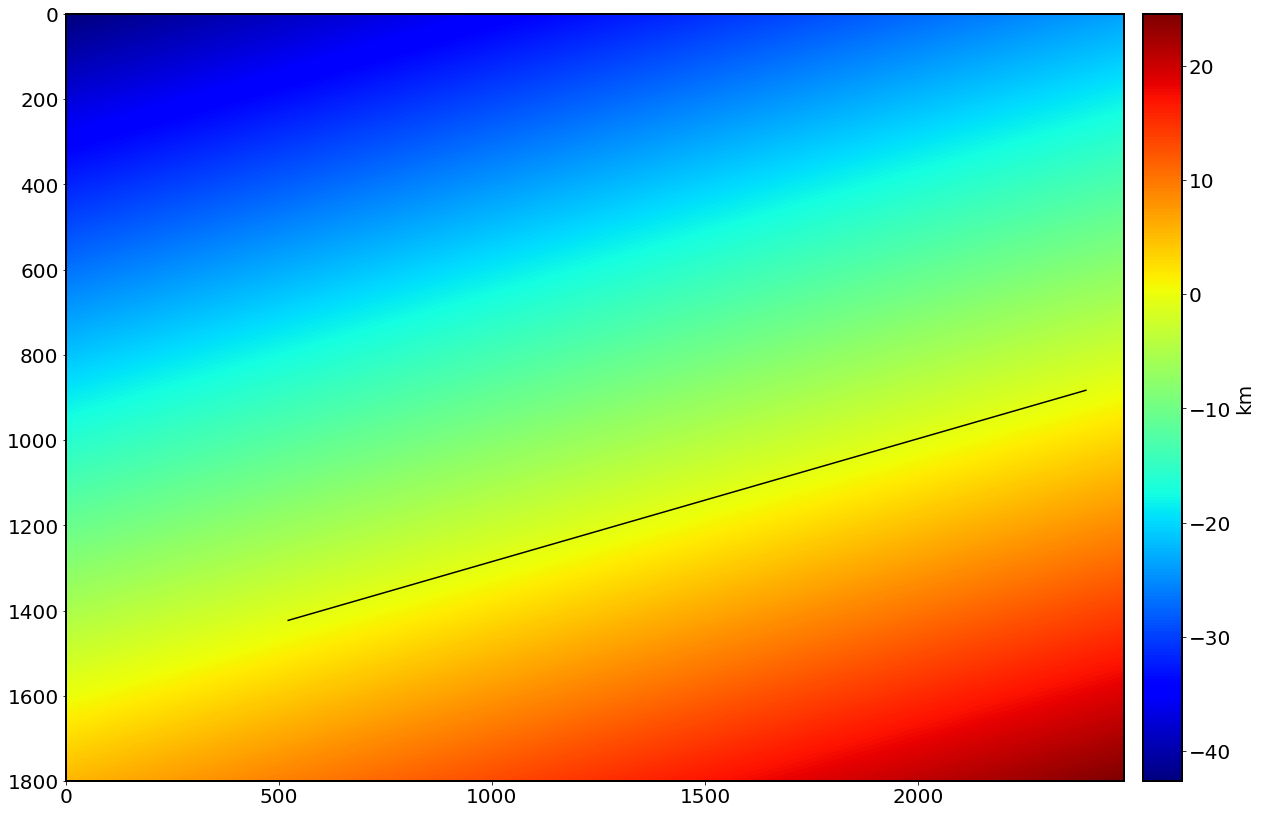

In [48]:
# # Plot to see if distances calculated correctly

fig,ax = plt.subplots()
FigDist = ax.imshow(dist_sh*100,cmap='jet')
# ax.invert_yaxis()
FigFault = plt.plot([f1_x,f2_x],[f1_y,f2_y],'k')
# plt.xticks(locsX,np.round(X[locsX],1))
# plt.yticks(locsY,np.round(Y[locsY],1))
add_colorbar(FigDist,label='km')
fig.savefig('dist.png')

In [24]:
# #Invert for locking depth using far-field velocity from GPS (Ergintav et al., 2014)

# ref_y = atr['ref_y']
# ref_x = atr['ref_x']

# D = np.arange(0.01,100000,100)
# VelLos = enu2los(0.020,0,0)
# rms = []
# for d in D:
#     Model = ((-VelLos/np.pi)*np.arctan(dist/d))
#     RefModel = Model-Model[ref_y][ref_x]
#     residual = RefModel - vel
#     rmse = np.sqrt(((residual - residual.mean(axis=0))**2).mean())
#     rms.append([d,rmse])
# rms = np.array(rms)

In [25]:
# Find the minimum RMS locking depth parameter

# idx = np.argmin(rms[:,1])
# rms_min = rms[idx]
# print(rms_min[0],'meters')

In [26]:
# D =9000.
# VelLos = enu2los(0.02,0,0)
# Model = (-VelLos/np.pi)*np.arctan(dist/D)

In [27]:
# #Plug the new locking depth into the model and plot

# Model = (-VelLos/np.pi)*np.arctan(dist/rms_min[0])
# RefModel = Model-Model[ref_y][ref_x]

# fig,ax = plt.subplots()
# FigModel = ax.imshow(RefModel,vmin=-0.020,vmax=0.020,cmap='jet')
# ax.invert_yaxis()
# plt.plot(Fx,Fy,'k')
# plt.title('Model from GPS')
# add_colorbar(FigModel)
# fig.savefig('Model.png')

In [28]:
# Residual = vel - RefModel

In [29]:
# fig,ax = plt.subplots()
# FigRes = ax.imshow(Residual,vmin=-0.02,vmax=0.02,cmap='jet')
# ax.invert_yaxis()
# plt.plot(Fx,Fy,'k')
# plt.title('Residual = Velocity - Model from GPS')
# add_colorbar(FigRes)
# fig.savefig('Residual.png')

In [30]:
# fig,ax = plt.subplots()
# FigRess = ax.imshow(vel-Residual,vmin=-0.02,vmax=0.02,cmap='jet')
# FigFault = plt.plot(Fx,Fy,'k')
# ax.invert_yaxis()
# plt.title('Model = Velocity - Residual')
# plt.xlim(0,vel.shape[1])
# add_colorbar(FigRess)
# fig.savefig('Vel-Res.png')

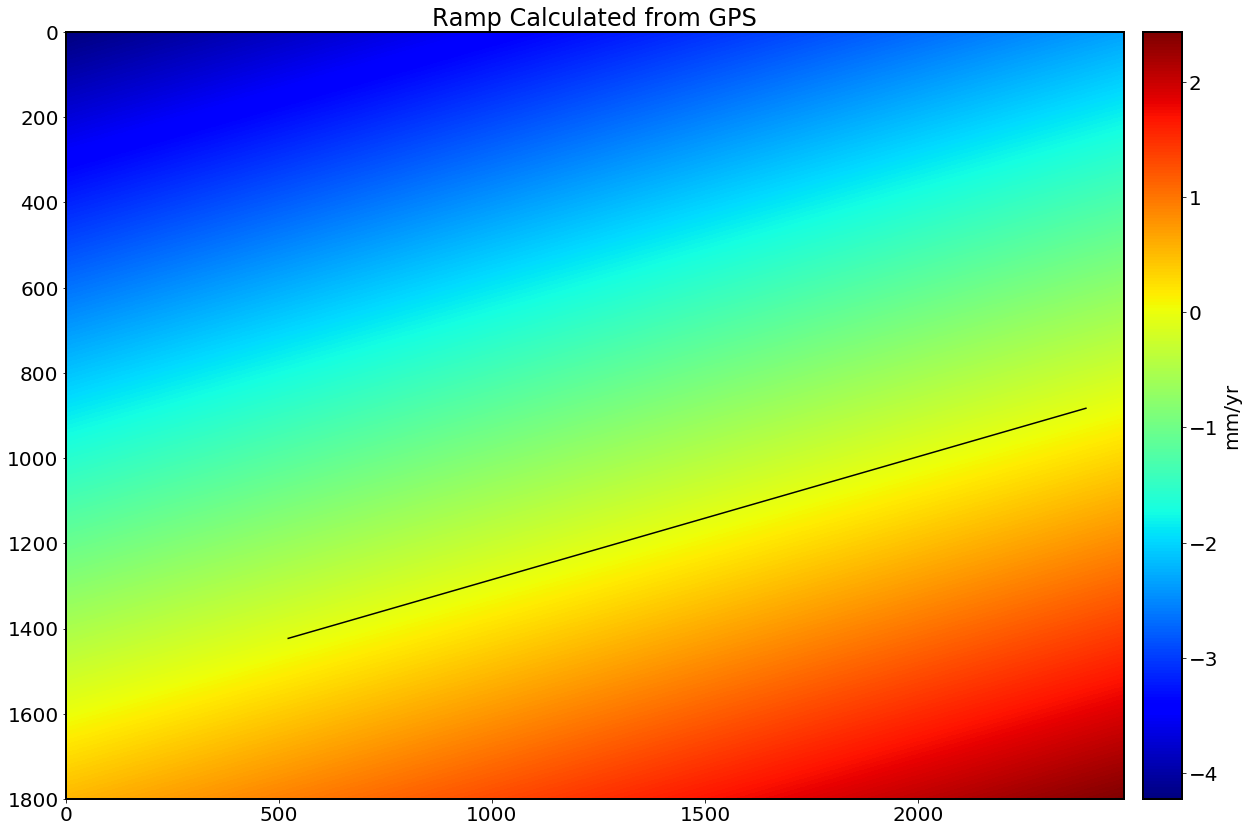

In [51]:
#Define ramp by distance
VelLos = enu2los(0.02,0,0)
DistMax = np.amax(dist_sh)+abs(np.amin(dist_sh))
plane = (dist_sh*-VelLos)/1.10 #1.10 is 110 km which comes from Ergintav et al 2014 as the longest distance between GPS points
# planeRef = plane-plane[686][0]
planeRef = plane

fig,ax = plt.subplots()
FigPlane = ax.imshow(planeRef*1000.,cmap='jet')
# ax.invert_yaxis()
FigFault = plt.plot([f1_x,f2_x],[f1_y,f2_y],'k')
add_colorbar(FigPlane,label='mm/yr')
plt.title('Ramp Calculated from GPS')
fig.savefig('ramp.png')

In [32]:
DistMax

0.6713087604732608

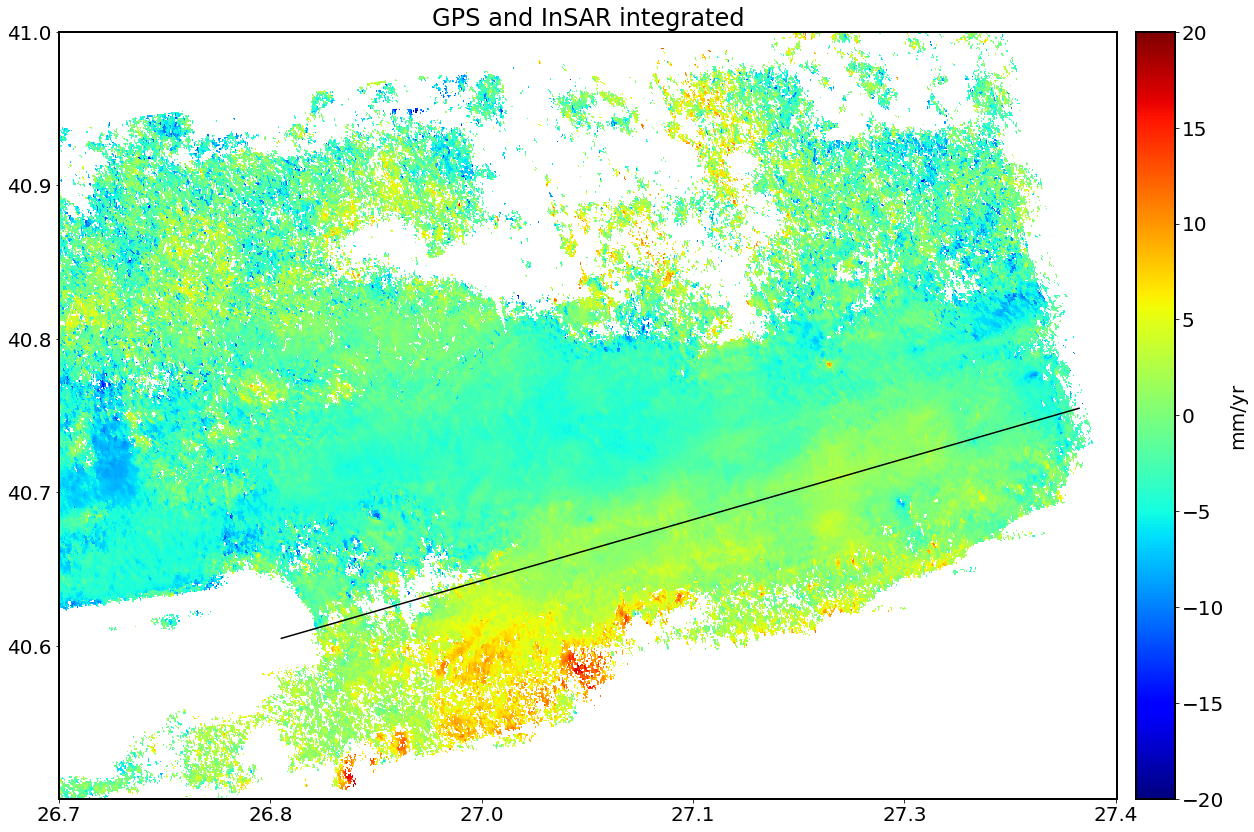

In [52]:
inGPS = planeRef + drmpdVel

fig,ax = plt.subplots()
FiginGPS = ax.imshow(inGPS*1000.,vmin =-20,vmax=20,cmap='jet')
# ax.invert_yaxis()
FigFault = plt.plot([f1_x,f2_x],[f1_y,f2_y],'k')
locsX = np.arange(0,np.int(atr['XMAX'])+1,np.int((np.int(atr['XMAX'])+1)/5))
locsY = np.arange(0,np.int(atr['YMAX'])+1,np.int((np.int(atr['YMAX'])+1)/5))
plt.xticks(locsX,np.round(X[locsX],1))
plt.yticks(locsY,np.round(Y[locsY],1))
add_colorbar(FiginGPS,label='mm/yr')
plt.title('GPS and InSAR integrated')
fig.savefig('integrated.png')

In [53]:
#Invert for locking depth using far-field velocity from GPS (Ergintav et al., 2014)
# %time
# ref_y = atr['ref_y']
# ref_x = atr['ref_x']

# D = np.arange(0.01,50000,100)
# S = np.arange(0,0.05,0.001)
# rms = []
# for d in D:
#     for s in S:
#         Model = ((s/np.pi)*np.arctan(dist/d))
# #         RefModel = Model-Model[ref_y][ref_x]
#         RefModel = Model
#         residual = integrated-RefModel 
#         rmse = np.sqrt(((residual - residual.mean(axis=0))**2).mean())
#         rms.append([d,s,rmse])
# rms = np.array(rms)

In [54]:
# Find the minimum RMS locking depth parameter

# idx = np.argmin(rms[:,2])
# rms_min = rms[idx]
# print(rms_min[0],'meters',rms_min[1]*1000.,'mm/yr')

In [81]:
%%time
# transect = transect_yx(dem,demRsc,[10,15],[100,115])
# atr['LENGTH'] = atr.pop('FILE_LENGTH')
start_yx = [350,250]
end_yx = [1750,650]
size = 1850
XX0,XX1,YY0,YY1,Dist,transectA = transect_yx(inGPS,atr,start_yx,end_yx,[f1_y,f1_x],[f2_y,f2_x],size)
DistM = Dist*10.

directory = './transect_'+str(start_yx[0])+'_'+str(start_yx[1])+'/'
# tranDict = {}
# tranDict['datavec'] = transectA
# tranDict['Distance_along_profile'] = Dist
# sio.savemat('./tranTest.mat', {'dataset':tranDict})

CPU times: user 179 ms, sys: 3.48 ms, total: 183 ms
Wall time: 182 ms


In [82]:
print([XX0[-1], XX1[-1]], [YY0[-1], YY1[-1]])
XX0m1_coor = (XX0[-1]*Xstep)+Xfirst
XX1m1_coor = (XX1[-1]*Xstep)+Xfirst
YY0m1_coor = (YY0[-1]*Ystep)+Yfirst
YY1m1_coor = (YY1[-1]*Ystep)+Yfirst
print(XX0m1_coor,XX1m1_coor,YY0m1_coor,YY1m1_coor)

[2026.5563073492185, 2429.5563073492185] [-162.4926212324517, 1234.5073787675483]
27.262932307598017 27.37487675204255 41.04513683923047 40.65708128367461


In [83]:
XX0_coor = (XX0[0]*Xstep)+Xfirst
XX1_coor = (XX1[0]*Xstep)+Xfirst
YY0_coor = (YY0[0]*Ystep)+Yfirst
YY1_coor = (YY1[0]*Ystep)+Yfirst
print(XX0_coor,XX1_coor,YY0_coor,YY1_coor)

26.76944444444506 26.881388888889596 40.9027777777769 40.51472222222103


Text(0.5,1,'Trasect Area')

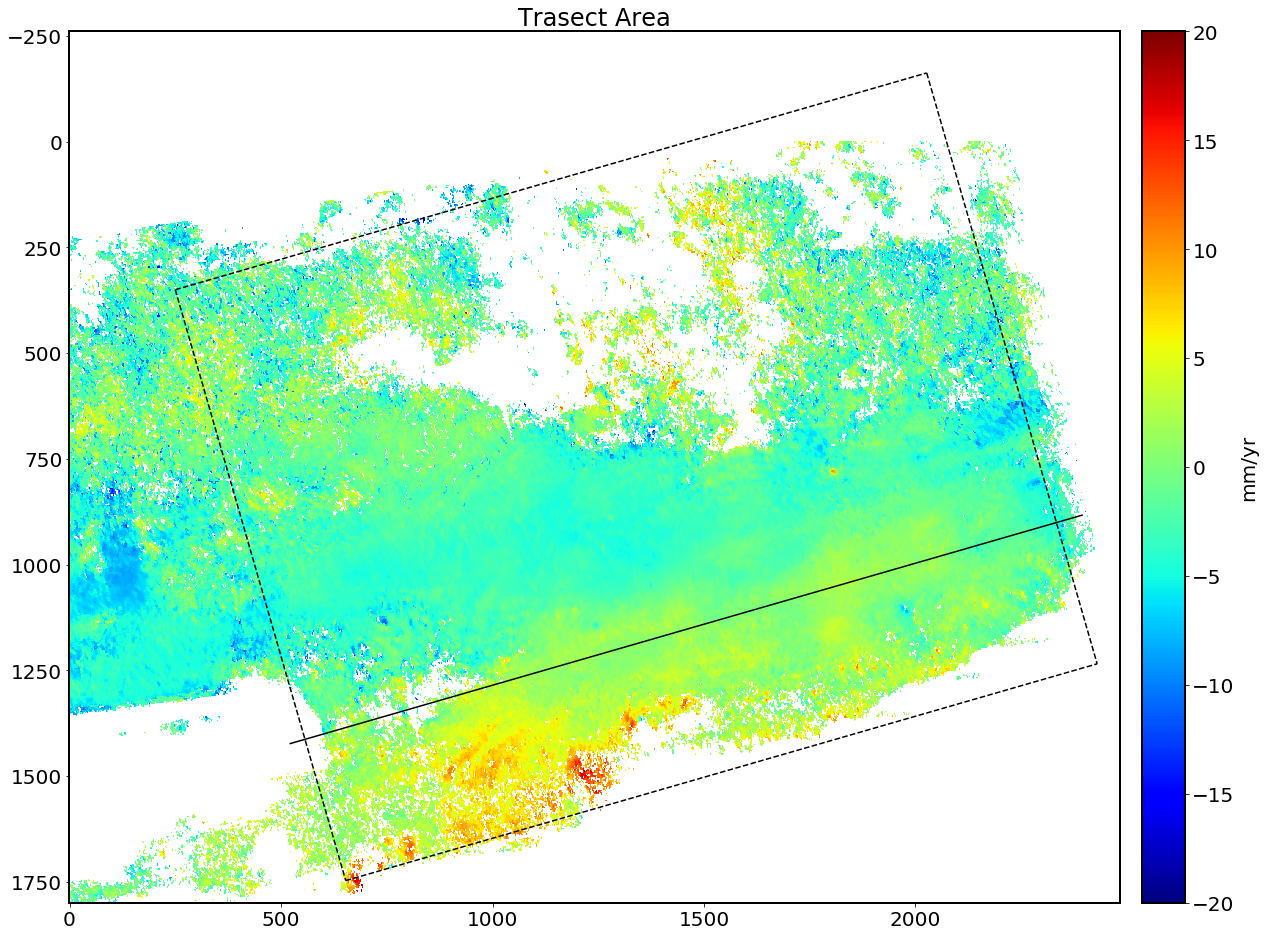

In [90]:
fig,ax = plt.subplots()
FiginGPS = ax.imshow(inGPS*1000.,vmin = -20,vmax=20,cmap='jet')
# ax.invert_yaxis()
FigFault = plt.plot([f1_x,f2_x],[f1_y,f2_y],'k')
# locsX = np.arange(0,np.int(atr['XMAX'])+1,np.int((np.int(atr['XMAX'])+1)/5))
# locsY = np.arange(0,np.int(atr['YMAX'])+1,np.int((np.int(atr['YMAX'])+1)/5))
# plt.xticks(locsX,np.round(X[locsX],1))
# plt.yticks(locsY,np.round(Y[locsY],1))


plt.plot([XX0[0], XX1[0]], [YY0[0], YY1[0]], 'k--')
plt.plot([XX0[-1], XX1[-1]], [YY0[-1], YY1[-1]], 'k--')
plt.plot([XX0[0], XX0[-1]], [YY0[0], YY0[-1]], 'k--')
plt.plot([XX1[0], XX1[-1]], [YY1[0], YY1[-1]], 'k--')

add_colorbar(FiginGPS,label='mm/yr')
plt.title('Trasect Area')

In [91]:
# filename = directory+'transect_'+str(start_yx[0])+'_'+str(start_yx[1])+'_'+str(size)+'.h5'
filename =  '../../../Desktop/sympocito/transect_'+str(start_yx[0])+'_'+str(start_yx[1])+'_'+str(size)+'.h5'
os.makedirs(os.path.dirname(filename), exist_ok=True)

g = h5py.File(filename,'w')
tranGroup = g.create_dataset('transect',data = transectA)
distGroup = g.create_dataset('distance',data = DistM)
g.close()

fig.savefig('../../../Desktop/sympocito/Transect_Area_'+str(start_yx[0])+'_'+str(start_yx[1])+'_'+str(size))

In [56]:
avgInSAR=np.array(np.nanmean(transectA,axis=1))
stdInSAR=np.array(np.nanstd(transectA,axis=1))


/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [57]:
G = np.ones([len(transectA),2])
G[:,0] = DistM
G_inv = np.dot(np.linalg.inv(np.dot(G.T,G)), G.T)
G_inv = np.array(G_inv, np.float32)
sol = np.dot(G_inv,avgInSAR)

In [58]:
%%time
D = np.arange(0.01,50000,100)
S = np.arange(0,0.05,0.001)
Q = np.arange(-5000,5000,100)

rms_inv = []

for d in D:
    for s in S:
        for q in Q:
            DistMo = DistM+q
            Model = ((s/np.pi)*np.arctan(DistMo/d))+sol[0]+sol[1]
            residual = avgInSAR - Model
            rmse = np.sqrt(np.nanmean(np.square(residual)))
            rms_inv.append([d,s,q,rmse])
        
rms = np.array(rms_inv)
idx = np.argmin(rms[:,3])
rms_min = rms[idx]
print('Locking depth: ',rms_min[0],'meters','Slip rate: ',rms_min[1]*1000,'mm/yr',' Offset from fault: ',rms_min[2],'meters','RMS:',rms_min[3]) 
##Negative rms_min[2] means south of the fault.##
ModelMin = ((rms_min[1]/np.pi)*np.arctan((DistM+rms_min[2])/rms_min[0]))+sol[0]+sol[1]

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


Locking depth:  0.01 meters Slip rate:  0.0 mm/yr  Offset from fault:  -5000.0 meters RMS: nan
CPU times: user 2min 59s, sys: 843 ms, total: 3min
Wall time: 3min


FileNotFoundError: [Errno 2] No such file or directory: './transect_250_600//Transect_250_600_50.png'

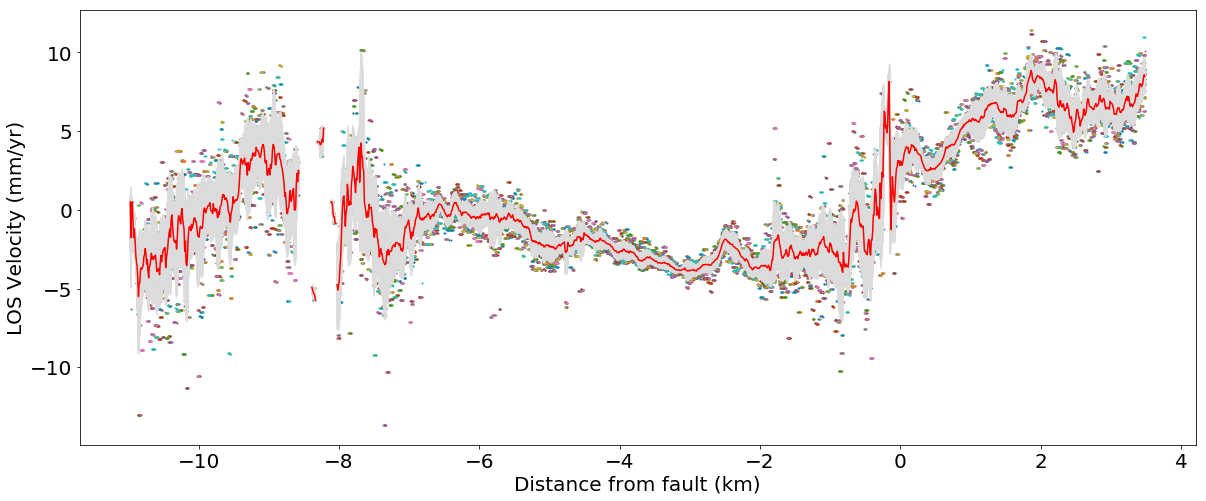

In [59]:
fig = plt.figure()
fig.set_size_inches(20,8)
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax=fig.add_subplot(111)
ax.plot(DistM/1000,transectA*1000,'o',ms=1,mfc='Black', linewidth='0')

for i in np.arange(0.0,1.01,0.01):
    ax.plot(DistM/1000, (avgInSAR-i*stdInSAR)*1000, '-',color='#DCDCDC',alpha=0.5)#,color='#DCDCDC')#'LightGrey')
for i in np.arange(0.0,1.01,0.01):
    ax.plot(DistM/1000, (avgInSAR+i*stdInSAR)*1000, '-',color='#DCDCDC',alpha=0.5)#'LightGrey')

ax.plot(DistM/1000, avgInSAR*1000, 'r-')
ax.plot(DistM/1000, ModelMin*1000.,'k--')
plt.xlabel('Distance from fault (km)')
plt.ylabel('LOS Velocity (mm/yr)')

fig.savefig(directory+'/Transect_'+str(start_yx[0])+'_'+str(start_yx[1])+'_'+str(size))

In [39]:
%time
D = np.arange(0.01,50000,100)
rms_inv = []
s=-VelLos
Q = np.arange(-10000,10000,100)

for q in Q:
    DistMo = DistM+q
    for d in D:
        Model = ((s/np.pi)*np.arctan(DistMo/d))+sol[0]+sol[1]
        residual = avgInSAR - Model
        rmse = np.sqrt(np.nanmean(np.square(residual)))
        rms_inv.append([d,q,rmse])
rms = np.array(rms_inv)
idx = np.argmin(rms[:,2])
rms_min = rms[idx]
print('Locking depth: ',rms_min[0],'meters',' Offset from fault: ',rms_min[1],' meters','RMS: ',rms_min[2])
ModelMin = ((s/np.pi)*np.arctan((DistM+rms_min[1])/rms_min[0]))+sol[0]+sol[1]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Locking depth:  7200.01 meters  Offset from fault:  -100.0  meters RMS:  0.0019432419255397443


In [83]:
-VelLos

0.01090276622508268

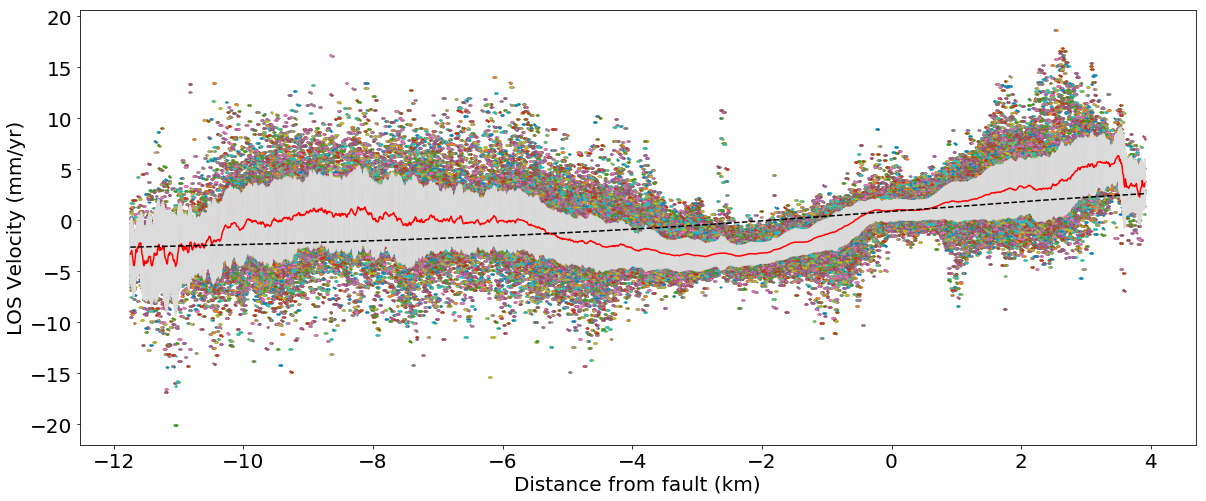

In [40]:
fig = plt.figure()
fig.set_size_inches(20,8)
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax=fig.add_subplot(111)
ax.plot(DistM/1000,transectA*1000,'o',ms=1,mfc='Black', linewidth='0')

for i in np.arange(0.0,1.01,0.01):
    ax.plot(DistM/1000, (avgInSAR-i*stdInSAR)*1000, '-',color='#DCDCDC',alpha=0.5)#,color='#DCDCDC')#'LightGrey')
for i in np.arange(0.0,1.01,0.01):
    ax.plot(DistM/1000, (avgInSAR+i*stdInSAR)*1000, '-',color='#DCDCDC',alpha=0.5)#'LightGrey')

ax.plot(DistM/1000, avgInSAR*1000, 'r-')
ax.plot(DistM/1000, ModelMin*1000.,'k--')
plt.xlabel('Distance from fault (km)')
plt.ylabel('LOS Velocity (mm/yr)')

fig.savefig(directory+'/Transect_LOSfixed_'+str(start_yx[0])+'_'+str(start_yx[1])+'_'+str(size))

In [128]:
transectmat = sio.loadmat('tranTest.mat')
transect = transectmat['dataset']

In [138]:
tr = transectmat['dataset']['datavec']
tr

array([[array([[-0.04387769, -0.04392452, -0.04399364, ...,  0.01059705,
         0.01581074,  0.00868422],
       [-0.04809445, -0.04809755, -0.04810101, ...,  0.00337353,
         0.01132633,  0.00600693],
       [-0.04808712, -0.0480896 , -0.04809355, ...,  0.00353874,
         0.00072132,  0.00600693],
       ...,
       [-0.03506765, -0.03579938, -0.02915833, ..., -0.02309647,
        -0.00156642,  0.00176969],
       [-0.03614596, -0.03629327, -0.02428849, ..., -0.00113398,
         0.01315266, -0.01015579],
       [-0.03587871, -0.03503468, -0.02504347, ..., -0.01425518,
         0.00702542, -0.00182501]])]], dtype=object)

In [18]:
idx = np.argmin(rms[:,2])
rms_min = rms[idx]
print(rms_min[0],'meters',rms_min[1]*1000.,'mm/yr')

0.01 meters 0.0 mm/yr


Text(0,0.5,'LOS Velocity (mm/yr)')

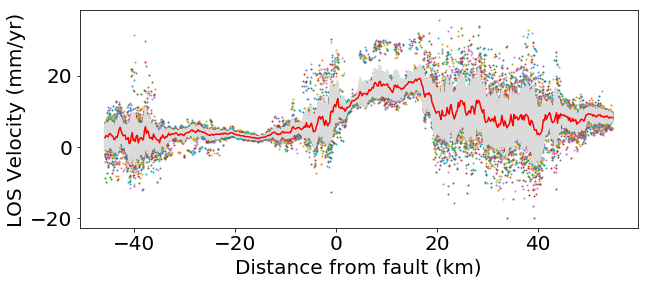

In [33]:
fig = plt.figure()
fig.set_size_inches(10,4)
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax=fig.add_subplot(111)
ax.plot(D/1000.0,transectA*1000,'o',ms=1,mfc='Black', linewidth='0')

for i in np.arange(0.0,1.01,0.01):
    ax.plot(D/1000.0, (avgInSAR-i*stdInSAR)*1000, '-',color='#DCDCDC',alpha=0.5)#,color='#DCDCDC')#'LightGrey')
for i in np.arange(0.0,1.01,0.01):
    ax.plot(D/1000.0, (avgInSAR+i*stdInSAR)*1000, '-',color='#DCDCDC',alpha=0.5)#'LightGrey')

ax.plot(D/1000.0, avgInSAR*1000, 'r-')
ax.plot(rms_min[0],rms_min[1]*1000.)
plt.xlabel('Distance from fault (km)')
plt.ylabel('LOS Velocity (mm/yr)')

NameError: name 'df0' is not defined

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


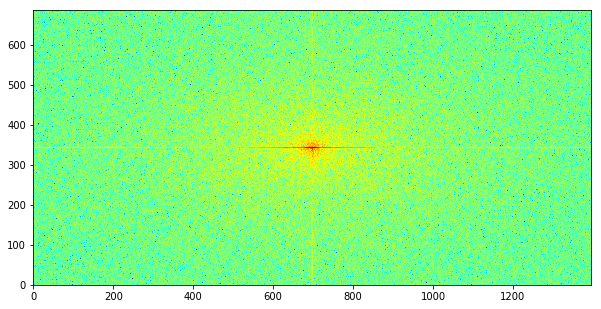

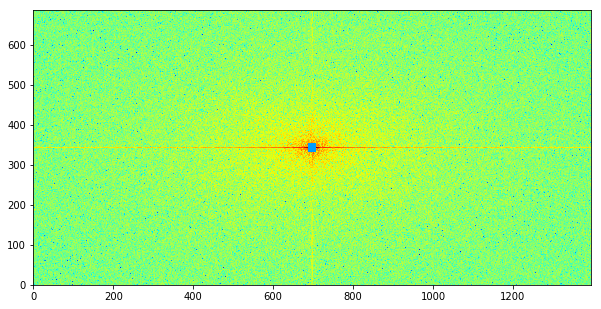

<Figure size 720x720 with 0 Axes>

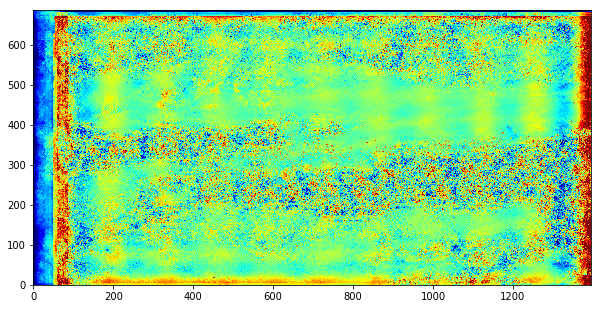

<Figure size 720x720 with 0 Axes>

In [80]:
ResFilt = np.zeros((vel.shape[0],vel.shape[1]))

resFft = np.fft.fft2(Residual)
shift = np.fft.fftshift(resFft)
psd2D = np.abs(shift)**2

fig,ax = plt.subplots()
FigRess = ax.imshow(np.log10(psd2D),cmap='jet')
# FigFault = plt.plot(Fx,Fy,'k')
ax.invert_yaxis()
# plt.title('Filtered')
# plt.xlim(0,vel.shape[1])
# add_colorbar(FigRess)
# fig.savefig('Filtered.png')

(w, h) = Residual.shape
half_w, half_h = int(w/2), int(h/2)

# high pass filter
n = 10
shift[half_w-n:half_w+n+1,half_h-n:half_h+n+1] = 0 # select all but the first 50x50 (low) frequencies

fig,ax = plt.subplots()
plt.figure(figsize=(10,10))
ax.imshow( (20*np.log10( 0.1 + shift)).astype(int),cmap='jet')
ax.invert_yaxis()
plt.show()


im1 = np.fft.ifft2(np.fft.ifftshift(shift)).real

fig,ax = plt.subplots()
plt.figure(figsize=(10,10))
ax.imshow(im1, vmin=-0.02,vmax=0.02,cmap='jet')
ax.invert_yaxis()
# plt.axis('off')
plt.show()




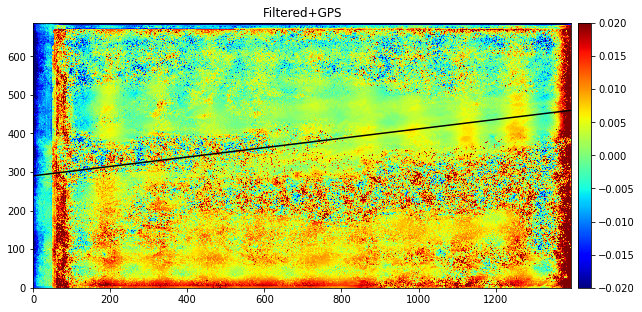

In [81]:
fig,ax = plt.subplots()
FigRess = ax.imshow(im1+RefModel,vmin=-0.02,vmax=0.02,cmap='jet')
FigFault = plt.plot(Fx,Fy,'k')
ax.invert_yaxis()
plt.title('Filtered+GPS')
plt.xlim(0,vel.shape[1])
add_colorbar(FigRess)
fig.savefig('Filtered+GPS.png')

In [27]:
##Shear stress and moment rate
V = 20 #mm/yr
D = 3.5 #km
mu = 30 #GPa
shr_strain = V/(np.pi*D)
stress = shr_strain * mu
acc_stress = stress*100.

moment_rate = mu*V*D*0.0001

print('Strain: ',shr_strain,' Stress: ',stress,' Accumulated Stress: ',acc_stress, 'Moment rate: ',moment_rate,'Nm/yr/km')

Strain:  1.8189136353359467  Stress:  54.567409060078404  Accumulated Stress:  5456.740906007841 Moment rate:  0.21000000000000002 Nm/yr/km


In [25]:
##Seismic moment rate per length
V = 20 #mm/yr
D = 9 #km
mu = 30 #GPa
moment_rate = mu*V*D


print('Moment rate',moment_rate,' Stress: ',stress,' Accumulated Stress: ',acc_stress)

Moment rate 5400  Stress:  21.22065907891938  Accumulated Stress:  2122.065907891938
